## LSTM Base

### Data Preparation
- doesn't work, gotta reduce dimension somehow

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys
import tensorflow as tf

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray

In [ ]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

# Creating one singular df
data_read=xr.merge([mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2])
tmp_data=data_read.to_dataframe().reset_index()

tmp_data=tmp_data.drop(columns=['bnds','TLONG', 'TLAT', 'time_bnds'])

chl_data=chl.Chl.to_dataframe().reset_index()
chl_data_socat=chl.Chl_socat.to_dataframe().reset_index()
pco2_data=pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat=pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['time', 'xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time', 'xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data.loc[:,features_socat]
combined=tmp_data.loc[:,features]

# drop rows where pco2 or pco2_socat == NA
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]
combined.dropna(subset = ["pCO2"], inplace=True)
combined= combined[combined['pCO2']!=0]




In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [4]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [5]:
X_socat=num_pipeline.fit_transform(X_socat)
X=num_pipeline.fit_transform(X)

In [64]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        X.append(dataset[i-window: i])
        y.append(target[i+1: i+1+horizon])
    return np.array(X), np.array(y) 

In [83]:
hist_window = 12
horizon = 3
TRAIN_SPLIT = 70
x_train, y_train = custom_ts_multi_data_prep(X_socat, y_socat, 0, TRAIN_SPLIT, hist_window, horizon)
x_val, y_val = custom_ts_multi_data_prep(X_socat, y_socat, TRAIN_SPLIT, None, hist_window, horizon) 


In [84]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0]) 

Multiple window of past history

[[-0.07443586 -0.08843568 -0.10375611 -0.28424737 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.27110335 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.25744955 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.24426008 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.24815058 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.24281223 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.23316099 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.23267539 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.23931498 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.25832402 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.25770887 -2.73929349]
 [-0.07443586 -0.08843568 -0.10375611 -0.26804242 -2.73929349]]

 Target horizon

[308.77089327 309.03954865 313.08428302]


In [102]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).repeat()

In [109]:
lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='relu'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,return_sequences=True)),
     tf.keras.layers.Dense(20, activation='relu'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
     tf.keras.layers.Dense(20, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 12, 400)           329600    
_________________________________________________________________
dense_28 (Dense)             (None, 12, 20)            8020      
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 12, 300)           205200    
_________________________________________________________________
dense_29 (Dense)             (None, 12, 20)            6020      
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               96800     
_________________________________________________________________
dense_30 (Dense)             (None, 20)                4020      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)               

In [110]:
model_path = '../models/Bidirectional_LSTM_Multivariate.h5'

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 


In [111]:
history = lstm_model.fit(train_data,epochs=20,steps_per_epoch=30,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/20
30/30 [==============================] - 15s 309ms/step - loss: 87312.2734 - val_loss: 101178.5078
Epoch 2/20
30/30 [==============================] - 4s 153ms/step - loss: 73383.7812 - val_loss: 85375.8125
Epoch 3/20
30/30 [==============================] - 5s 159ms/step - loss: 59245.1797 - val_loss: 68170.0000
Epoch 4/20
30/30 [==============================] - 5s 161ms/step - loss: 43893.1758 - val_loss: 50740.5234
Epoch 5/20
30/30 [==============================] - 5s 158ms/step - loss: 30354.4688 - val_loss: 35062.4570
Epoch 6/20
30/30 [==============================] - 5s 162ms/step - loss: 18949.7637 - val_loss: 22694.0273
Epoch 7/20
30/30 [==============================] - 5s 162ms/step - loss: 11289.3701 - val_loss: 14175.4990
Epoch 8/20
30/30 [==============================] - 5s 168ms/step - loss: 6928.6729 - val_loss: 8984.2959
Epoch 9/20
30/30 [==============================] - 5s 173ms/step - loss: 4642.9307 - val_loss: 6137.3687
Epoch 10/20
30/30 [===========

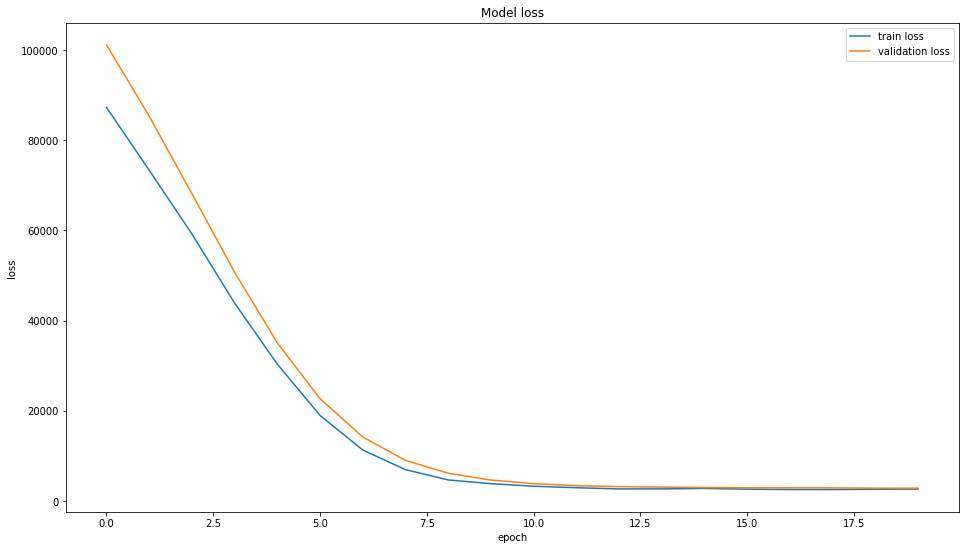

In [112]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

### Prediction

In [ ]:
x_input, y_input = custom_ts_multi_data_prep(X, y, 0, None, hist_window, horizon)



In [ ]:
print ('Multiple window of past history\n')
print(x_input[0])
print ('\n Target horizon\n')
print (y_input[0]) 

In [ ]:
y_predict=lstm.model(x_input,verbose=1)
y_predict